In [216]:
import numpy as np
import pandas as pd
import scipy.stats as sc_stats
import matplotlib.pyplot as plt

In [217]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 12,
  'grid.alpha': 0.25})

In [218]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)


In [219]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


In [220]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result

In [221]:
def read_ods(filename, columns):
  key_arr = (k for k in columns.keys())
  df = pd.read_excel(filename, engine="odf", header=0,
                     usecols=columns)
  df = df.rename(columns=columns)
  return df

In [222]:
def get_accuracy_measures(dataframe, columns=["Y_t", "hat_Y_t"]):
  Y_t = dataframe[columns[0]]
  hat_Y_t = dataframe[columns[1]]

  MAPE = (((Y_t - hat_Y_t).abs())/Y_t).mean()
  MAD = (Y_t - hat_Y_t).abs().mean()
  MSD = ((Y_t - hat_Y_t)**2).mean()
  
  return MAPE, MAD, MSD

In [223]:
filename = "table-2.ods"

df = read_ods(filename, {"Month": "t", "Price": "Y_t"})
df.head(10)

,t,Y_t
0,1,430
1,2,420
2,3,436
3,4,452
4,5,477
5,6,420
6,7,398
7,8,501
8,9,514
9,10,532


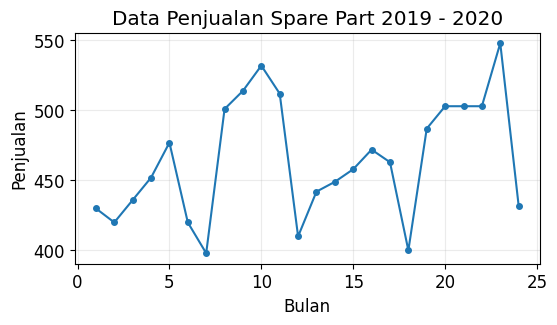

In [224]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df["t"], df["Y_t"], marker='o', markersize=4)
ax.set_xlabel("Bulan")
ax.set_ylabel("Penjualan")
ax.set_title("Data Penjualan Spare Part 2019 - 2020")
ax.grid("on")
plt.show(fig)

# autocorrelation for finding pattern

In [225]:
def std_error(r_k_arr, k, n):
  r_k_arr = np.array(r_k_arr)
  r_k_arr = r_k_arr[:k-1] if len(r_k_arr) > 1 else [0]
  r_k_arr = np.array(r_k_arr)
  return np.sqrt((1 + 2*sum(r_k_arr**2))/n)

In [226]:
def get_correlogram(dataframe, up_to_lag, columns=[None, None], 
                    significance_lvl=0.05):
  df = dataframe.copy()

  Y_t = df[columns[1]].to_numpy()

  mean_Y_t = np.mean(Y_t)

  r_lag_arr = np.empty(up_to_lag)
  denom = np.sum((Y_t - mean_Y_t)**2)

  num_of_samples = len(Y_t)
  dof = num_of_samples - 1   # degree of freedom
  l_bound = sc_stats.t.ppf(significance_lvl/2, dof)
  u_bound = sc_stats.t.ppf(1-significance_lvl/2, dof)
  #print(f"[l_bound, r_bound] = [{l_bound}, {u_bound}]")

  std_error_arr = np.empty(up_to_lag)
  significance_lim_arr = np.empty([up_to_lag, 2])

  t_test_arr = np.empty(up_to_lag)

  # Ljung-Box Q statistic
  coeff = num_of_samples*(num_of_samples + 2)
  LBQ_arr = np.empty(up_to_lag)

  for lag in range(1, up_to_lag+1):
    numer = (Y_t[:-lag]  - mean_Y_t) * (Y_t[lag:] - mean_Y_t)
    numer = np.sum(numer)
    # print(f"numer = {numer}")
    # print(f"denom = {denom}")
    r_lag = numer / denom
    r_lag_arr[lag-1] = r_lag 
    std_error_arr[lag-1] = std_error(r_lag_arr[:lag], lag, num_of_samples)
    #print(f"std_error_r_{lag:<2d}: {std_error_arr[lag-1]}")
    significance_lim_arr[lag-1, 0] = l_bound*std_error_arr[lag-1]
    significance_lim_arr[lag-1, 1] = u_bound*std_error_arr[lag-1]

    t_test_arr[lag-1] = r_lag / std_error_arr[lag-1]
    # print(f"r_{lag:<2d} = {r_lag_arr[lag-1]:9.6f}")

    LBQ_arr[lag-1] = coeff*np.sum((r_lag_arr[:lag]**2)/(num_of_samples - np.arange(1, lag+1)))


  df_result = pd.DataFrame({
    "k": np.arange(1, up_to_lag+1), 
    "r_k": r_lag_arr, 
    "t_test": t_test_arr, 
    "LBQ": LBQ_arr,
    "l_bound": significance_lim_arr[:,0],
    "u_bound": significance_lim_arr[:,1]  
  })
  return df_result


In [227]:
def plot_autocorr_func(df_acorr_analysis, title=None):
  fig, ax = plt.subplots(figsize=(7, 3))

  lag_arr = df_acorr_analysis["k"].to_numpy()
  stem_handler = ax.stem(lag_arr, df_acorr_analysis["r_k"].to_numpy())

  ax.plot(lag_arr, df_acorr_analysis["l_bound"], linestyle='--', color="gray")
  ax.plot(lag_arr, df_acorr_analysis["u_bound"], linestyle='--', color="gray")

  # [0] = markerline handler
  # [1] = stemlines handler
  # [2] = baseline handler
  stem_handler[0].set_marker(None)
  stem_handler[1].set_linewidth(4)
  stem_handler[2].set_alpha(0)

  ax.grid("on")
  ax.set_ylim([-1.1, 1.1])
  ax.set_xlabel("Lag")
  ax.set_ylabel("Autocorrelation")
  ax.set_title(f"Autocorrelation Function for {title}\n"
    + "(with 5% significance limits for the autocorrelations)")

  plt.show(fig)


In [228]:
num_of_rk = 12
df_acorr_analysis = get_correlogram(df, num_of_rk, columns=['t', "Y_t"])
df_acorr_analysis

,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,0.314606,1.541248,2.685286,-0.422263,0.422263
1,2,-0.041892,-0.187507,2.735062,-0.462171,0.462171
2,3,-0.151831,-0.678597,3.420058,-0.462848,0.462848
3,4,-0.193279,-0.847732,4.585594,-0.471645,0.471645
4,5,-0.033347,-0.142069,4.622115,-0.485563,0.485563
5,6,0.163607,0.696433,5.550043,-0.485971,0.485971
6,7,-0.236476,-0.986872,7.602661,-0.495695,0.495695
7,8,-0.284581,-1.142184,10.761135,-0.515417,0.515417
8,9,-0.165022,-0.629014,11.893992,-0.542712,0.542712
9,10,0.024686,0.092583,11.921154,-0.551586,0.551586


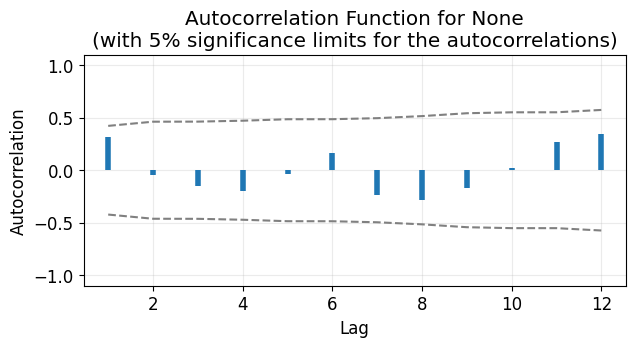

In [229]:
plot_autocorr_func(df_acorr_analysis)

# Forecast with naive

In [230]:
df_forecast_naive = df.copy()
df_forecast_naive["hat_Y_t"] = df_forecast_naive["Y_t"].shift(1)
df_forecast_naive["e_t"] = df_forecast_naive["Y_t"] - df_forecast_naive["hat_Y_t"]
df_forecast_naive 

,t,Y_t,hat_Y_t,e_t
0,1,430,NaN,NaN
1,2,420,430.0,-10.0
2,3,436,420.0,16.0
3,4,452,436.0,16.0
4,5,477,452.0,25.0
5,6,420,477.0,-57.0
6,7,398,420.0,-22.0
7,8,501,398.0,103.0
8,9,514,501.0,13.0
9,10,532,514.0,18.0


In [231]:
df_forecast_naive.to_excel("no-2-b.xlsx")

In [232]:
Y_t = df_forecast_naive["Y_t"]
hat_Y_t = df_forecast_naive["hat_Y_t"]
MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
print(f"MAPE   {MAPE*100:9.2f}%")

MAPE        7.68%


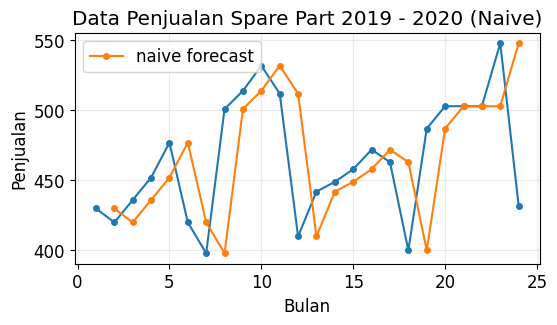

In [233]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast_naive["t"], df_forecast_naive["Y_t"], 
  marker='o', markersize=4)
ax.plot(df_forecast_naive["t"], df_forecast_naive["hat_Y_t"], 
  marker='o', markersize=4, label='naive forecast')

ax.set_xlabel("Bulan")
ax.set_ylabel("Penjualan")
ax.set_title("Data Penjualan Spare Part 2019 - 2020 (Naive)")
ax.grid("on")
ax.legend(loc="best")
plt.show(fig)


# Forecast with Exponential Smoothing

In [234]:
df_forecast_exponen = df.copy()

# Append the first row with Y_1 to correct the initial data
# for hat_Y_t
init_hat_Y_t = df_forecast_exponen["Y_t"][0]
data = []
data.insert(0, {"Y_t": init_hat_Y_t})
df_forecast_exponen = pd.concat([pd.DataFrame(data), df_forecast_exponen], ignore_index=True)

alpha = 0.5
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
residual_key = f"e_t_alpha_{alpha:.1f}"
df_forecast_exponen[forecast_key] = df_forecast_exponen["Y_t"].ewm(alpha=alpha, adjust=False).mean().shift(1)
df_forecast_exponen[residual_key] = df_forecast_exponen["Y_t"] - df_forecast_exponen[forecast_key]

df_forecast_exponen = df_forecast_exponen.drop([0]).reset_index(drop=True)

df_forecast_exponen

,Y_t,t,hat_Y_t_alpha_0.5,e_t_alpha_0.5
0,430,1.0,430.000000,0.000000
1,420,2.0,430.000000,-10.000000
2,436,3.0,425.000000,11.000000
3,452,4.0,430.500000,21.500000
4,477,5.0,441.250000,35.750000
5,420,6.0,459.125000,-39.125000
6,398,7.0,439.562500,-41.562500
7,501,8.0,418.781250,82.218750
8,514,9.0,459.890625,54.109375
9,532,10.0,486.945312,45.054688


In [235]:
df_forecast_exponen.to_excel("no-2-c.xlsx")

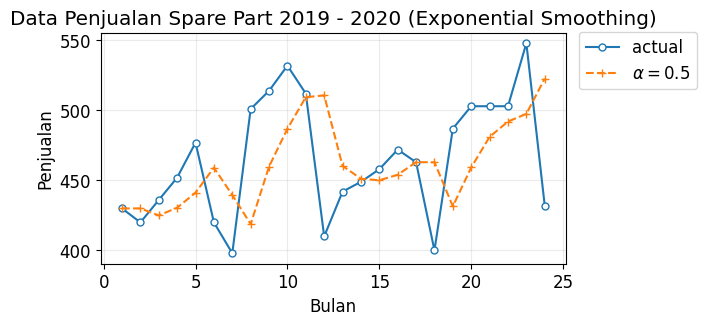

In [236]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast_exponen["t"], df_forecast_exponen["Y_t"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="actual")

alpha = 0.5
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
ax.plot(df_forecast_exponen["t"], df_forecast_exponen[forecast_key], 
  marker='+', markersize=6, linestyle='--', 
  label=r"$\alpha = $"+f"{alpha}")

ax.set_xlabel("Bulan")
ax.set_ylabel("Penjualan")
ax.set_title("Data Penjualan Spare Part 2019 - 2020 (Exponential Smoothing)")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)


In [237]:
alpha = 0.5
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
MAPE, _ , MSE = get_accuracy_measures(df_forecast_exponen, columns=["Y_t", forecast_key])
print(f"  MAPE    {MAPE*100:>9.1f}%")

  MAPE          7.5%


# Forecasting using Winter's method 


In [238]:
df_forecast_winter = df.copy()

Y_t = df_forecast_winter["Y_t"].to_numpy()

alpha = 0.5
beta = 0.5
gamma = 0.5
p = 1
s = 12

# The initial setting is only for RS Sejahtera

# Initial level, di dapatkan dari rata - rata 12 bulan
init_L_t = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 458.50]

#  Initial Trend, 18 bulan pertama dikurangi 18 bulan selanjutnya kemudian dibagi 18 kemudian diambil rata2 dari pembagian tersebut.
init_T_t = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.10]

# Initial Season, didapat dari rata rata 18 bulan pertama kemudian dibagi nilai setiap Y_t
init_S_t = [0.94, 0.92, 0.95, 0.99, 1.04, 0.92, 0.87, 1.09, 1.12, 1.16, 1.12, 0.89]

num_of_rows = len(Y_t)
L_t = np.empty(num_of_rows)
T_t = np.empty(num_of_rows)
S_t = np.empty(num_of_rows)
L_t[:12] = init_L_t
T_t[:12] = init_T_t
S_t[:12] = init_S_t

for i in range(12, len(df_forecast_winter)):
  L_t[i] = alpha*Y_t[i]/(S_t[i-s]) + (1 - alpha)*(L_t[i-1] + T_t[i-1]) 
  T_t[i] = beta*(L_t[i] - L_t[i-1]) + (1 - beta) * T_t[i-1]
  S_t[i] = gamma*Y_t[i]/L_t[i] + (1 - gamma)*S_t[i-s]


df_forecast_winter["L_t"] = L_t
df_forecast_winter["T_t"] = T_t
df_forecast_winter["S_t"] = S_t
df_forecast_winter["S_tMsPp"] = df_forecast_winter["S_t"].shift(s).shift(-p)

df_forecast_winter[f"hat_Y_tP{p}"] = ((df_forecast_winter["L_t"] + p*df_forecast_winter["T_t"]) \
  *df_forecast_winter["S_tMsPp"]).shift(p)

df_forecast_winter["e_t"] = df_forecast_winter["Y_t"] - df_forecast_winter[f"hat_Y_tP{p}"]

# Put NaN to the last quarter in 2006
L_t = df_forecast_winter["L_t"].to_numpy()
T_t = df_forecast_winter["T_t"].to_numpy()
S_t = df_forecast_winter["S_t"].to_numpy()


df_forecast_winter["L_t"] = L_t
df_forecast_winter["T_t"] = T_t 
df_forecast_winter["S_t"] = S_t


# Update hat_Y_tPp (the last four row have different p ranging from 1 to 12)
hat_Y_tPp = df_forecast_winter[f"hat_Y_tP{p}"].to_numpy()
L_t = df_forecast_winter["L_t"].to_numpy()
T_t = df_forecast_winter["T_t"].to_numpy()
S_t = df_forecast_winter["S_t"].to_numpy()
for p_i in range(s):
  hat_Y_tPp[-s+p_i] = (L_t[-s-1] + (p_i+1)*T_t[-s-1])*S_t[(-s-1)-s+(p_i+1)]
  
df_forecast_winter[f"hat_Y_tP{p}"] = hat_Y_tPp

df_forecast_winter


,t,Y_t,L_t,T_t,S_t,S_tMsPp,hat_Y_tP1,e_t
0,1,430,0.000000,0.000000,0.940000,NaN,NaN,NaN
1,2,420,0.000000,0.000000,0.920000,NaN,NaN,NaN
2,3,436,0.000000,0.000000,0.950000,NaN,NaN,NaN
3,4,452,0.000000,0.000000,0.990000,NaN,NaN,NaN
4,5,477,0.000000,0.000000,1.040000,NaN,NaN,NaN
5,6,420,0.000000,0.000000,0.920000,NaN,NaN,NaN
6,7,398,0.000000,0.000000,0.870000,NaN,NaN,NaN
7,8,501,0.000000,0.000000,1.090000,NaN,NaN,NaN
8,9,514,0.000000,0.000000,1.120000,NaN,NaN,NaN
9,10,532,0.000000,0.000000,1.160000,NaN,NaN,NaN


In [239]:
df_forecast_winter.to_excel("no-2-e.xlsx")

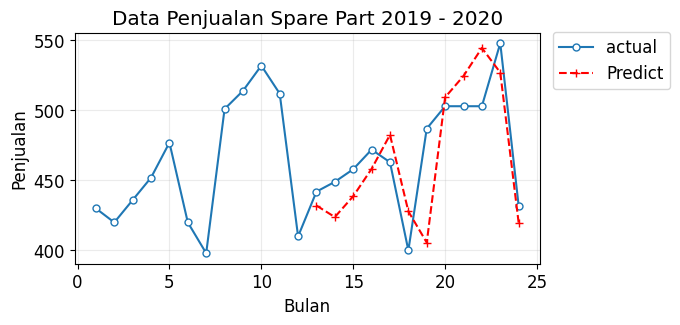

In [240]:
from turtle import color


fig, ax = plt.subplots(figsize=(6, 3))

ax.plot(df_forecast_winter["t"], df_forecast_winter["Y_t"], 
  marker='o', markersize=5, markerfacecolor='white',
  label="actual")

forecast_key = f"hat_Y_tP{p}"
ax.plot(df_forecast_winter["t"], df_forecast_winter[forecast_key], 
  marker='+', markersize=6, linestyle='--', color='red',
  label="Predict")

ax.set_xlabel("Bulan")
ax.set_ylabel("Penjualan")
ax.set_title("Data Penjualan Spare Part 2019 - 2020")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.04])
ax.grid("on")
plt.show(fig)


In [241]:
MAPE, _ , MSE = get_accuracy_measures(df_forecast_winter, columns=["Y_t", f"hat_Y_tP{p}"])
print(f"(alpha, beta, gamma) = ({alpha}, {beta}, {gamma})")
print(f"  MAPE    {MAPE*100:>9.1f}%")


(alpha, beta, gamma) = (0.5, 0.5, 0.5)
  MAPE          5.3%


In [242]:
num_of_rk = 6 

df_winter = df_forecast_winter.copy()
df_winter = df_winter.dropna().reset_index(drop=True)
df_acorr_analysis = get_correlogram(df_winter, num_of_rk, columns=['t', "e_t"])
df_acorr_analysis.head(10)


,k,r_k,t_test,LBQ,l_bound,u_bound
0,1,-0.189182,-0.627445,0.511793,-0.671809,0.671809
1,2,-0.380219,-1.218198,2.808791,-0.695437,0.695437
2,3,-0.247192,-0.702826,3.901025,-0.783662,0.783662
3,4,0.357736,0.974315,6.515366,-0.818097,0.818097
4,5,0.110606,0.278190,6.806935,-0.885889,0.885889
5,6,-0.071616,-0.178869,6.953619,-0.892100,0.892100


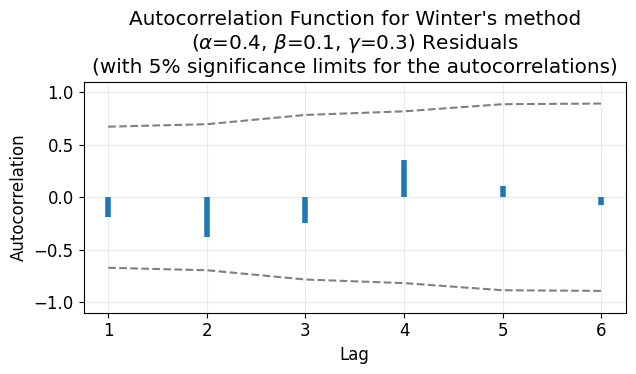

In [243]:
plot_autocorr_func(df_acorr_analysis, title="Winter's method\n"r"($\alpha$=0.4, $\beta$=0.1, $\gamma$=0.3) Residuals")

# Comparison MAPE

In [244]:
Y_t = df_forecast_naive["Y_t"]
hat_Y_t = df_forecast_naive["hat_Y_t"]
MAPE = (((Y_t - hat_Y_t).abs())/Y_t.abs()).mean()
print(f"MAPE Naive{MAPE*100:6.2f}%")

alpha = 0.5
forecast_key = f"hat_Y_t_alpha_{alpha:.1f}"
MAPE, _ , MSE = get_accuracy_measures(df_forecast_exponen, columns=["Y_t", forecast_key])
print(f"MAPE Exponential Smoothing{MAPE*100:>9.1f}%")

MAPE, _ , MSE = get_accuracy_measures(df_forecast_winter, columns=["Y_t", f"hat_Y_tP{p}"])
print(f"(alpha, beta, gamma) = ({alpha}, {beta}, {gamma})")
print(f"MAPE Winter{MAPE*100:>9.1f}%")

MAPE Naive  7.68%
MAPE Exponential Smoothing      7.5%
(alpha, beta, gamma) = (0.5, 0.5, 0.5)
MAPE Winter      5.3%
